# Dataset Description and Goal

### 📄 Author: Riski Pratama

### 📁 Tentang Dataset
Dataset **[FER2013](https://www.kaggle.com/datasets/msambare/fer2013/data)** terdiri dari gambar wajah berukuran 48x48 piksel dalam format grayscale (hitam-putih).  
Setiap wajah telah diproses secara otomatis agar posisinya terpusat dan proporsional, sehingga semua wajah terlihat konsisten dalam ukuran dan posisi.

---

### 🎯 Tujuan
Tujuan dari proyek ini adalah untuk **mengklasifikasikan ekspresi wajah** ke dalam salah satu dari **tiga kategori emosi utama**, yaitu:
- **Senang (Happy)**
- **Sedih (Sad)**
- **Netral (Neutral)**

Ketiga label ini dipilih dari tujuh label asli dalam dataset FER2013 berikut:
- 0 = Marah (Angry)  
- 1 = Jijik (Disgust)  
- 2 = Takut (Fear)  
- 3 = Senang (Happy)  
- 4 = Sedih (Sad)  
- 5 = Terkejut (Surprise)  
- 6 = Netral (Neutral)

Pemilihan label tersebut dilakukan karena:
- ✅ Merupakan **label mayoritas** dalam dataset.
- ✅ Lebih sering digunakan dalam studi dan aplikasi praktis.
- ✅ Bertujuan untuk:
  - Mengurangi **bias akibat ketidakseimbangan** jumlah data antar kelas.
  - Meningkatkan **akurasi model** pada label yang lebih representatif secara statistik.
  - Memperbaiki **kemampuan generalisasi** dalam penggunaan nyata seperti interaksi manusia-komputer.

---

### 📊 Distribusi Dataset
- **28.709 gambar** pada set data **training**
- **3.589 gambar** pada set data **testing**

# 1. Loading the Directories

## 1.1 Import Library

In [32]:
# 🔢 Manipulasi Data
import numpy as np

# 📊 Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# 📁 Sistem & File Handling
import os
import shutil

# 🧠 Evaluasi Model & Utilities Scikit-learn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# 🔧 TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers

In [2]:
!pip install kaggle

In [3]:
os.environ['KAGGLE_USERNAME'] = "Isi username API kaggle"
os.environ['KAGGLE_KEY'] = "Isi password API kaggle"

In [4]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip fer2013.zip -d fer2013

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: fer2013/train/sad/Training_65242339.jpg  
  inflating: fer2013/train/sad/Training_65267116.jpg  
  inflating: fer2013/train/sad/Training_65275626.jpg  
  inflating: fer2013/train/sad/Training_6529266.jpg  
  inflating: fer2013/train/sad/Training_65329617.jpg  
  inflating: fer2013/train/sad/Training_65338712.jpg  
  inflating: fer2013/train/sad/Training_65338797.jpg  
  inflating: fer2013/train/sad/Training_65387162.jpg  
  inflating: fer2013/train/sad/Training_65404494.jpg  
  inflating: fer2013/train/sad/Training_65426218.jpg  
  inflating: fer2013/train/sad/Training_65430136.jpg  
  inflating: fer2013/train/sad/Training_65437377.jpg  
  inflating: fer2013/train/sad/Training_6545735.jpg  
  inflating: fer2013/train/sad/Training_65463385.jpg  
  inflating: fer2013/train/sad/Training_65473985.jpg  
  inflating: fer2013/train/sad/Training_65502829.jpg  
  inflating: fer2013/train/sad/Training_65505359.jpg  
  inflat

# 2.Loading the Directories

In [6]:
# Label yang ingin dipertahankan
selected_labels = ['happy', 'sad', 'neutral']

# Lokasi folder dataset asli
original_train_dir = '/content/fer2013/train'
original_test_dir = '/content/fer2013/test'

# Lokasi folder dataset baru hasil filter
filtered_train_dir = '/content/fer2013_filtered/train'
filtered_test_dir = '/content/fer2013_filtered/test'

# Buat folder baru
os.makedirs(filtered_train_dir, exist_ok=True)
os.makedirs(filtered_test_dir, exist_ok=True)

# Salin folder label yang dipilih dari train
for label in selected_labels:
    src = os.path.join(original_train_dir, label)
    dst = os.path.join(filtered_train_dir, label)
    if not os.path.exists(dst):
        shutil.copytree(src, dst)

# Salin folder label yang dipilih dari test
for label in selected_labels:
    src = os.path.join(original_test_dir, label)
    dst = os.path.join(filtered_test_dir, label)
    if not os.path.exists(dst):
        shutil.copytree(src, dst)

In [7]:
train = '/content/fer2013_filtered/train'
test = '/content/fer2013_filtered/test'

# 3.Reading and Preprocessing Data from Directories

## 3.1 Augmentasi Images

In [8]:
img_size = (48, 48)
bth_size = 32

trdatagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,           # Meningkatkan rotasi hingga 30 derajat
    width_shift_range=0.25,      # Pergeseran horizontal lebih luas
    height_shift_range=0.25,     # Pergeseran vertikal lebih luas
    shear_range=0.25,            # Distorsi kemiringan lebih tinggi
    zoom_range=0.3,              # Zoom in/out lebih agresif
    horizontal_flip=True,        # Tetap dipertahankan
    brightness_range=[0.6, 1.4], # Menambahkan variasi pencahayaan
    fill_mode='nearest',         # Menangani area kosong akibat augmentasi
    validation_split=0.1         # Split validasi tetap
)

tedatagen = ImageDataGenerator(rescale=1.0/255)

## 3.2 Membagi Dataset (Training, Validation, Testing)


In [9]:
# Data training (90%)
traingen = trdatagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Data testing
testgen = tedatagen.flow_from_directory(
    test,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

# Data validasi (10%)
valgen = trdatagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 15310 images belonging to 3 classes.
Found 4254 images belonging to 3 classes.
Found 1700 images belonging to 3 classes.


# 4.Displaying Training and Testing Images

## 4.1 Menampilkan dataset pelatihan dan pengujian

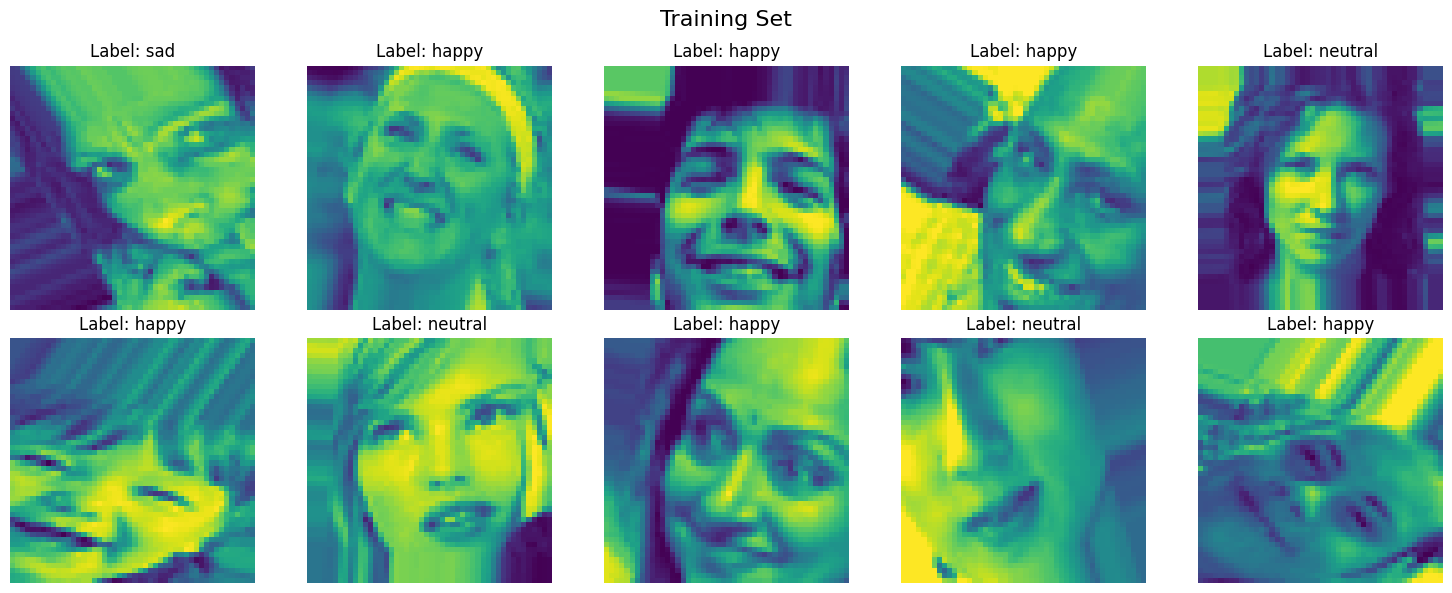

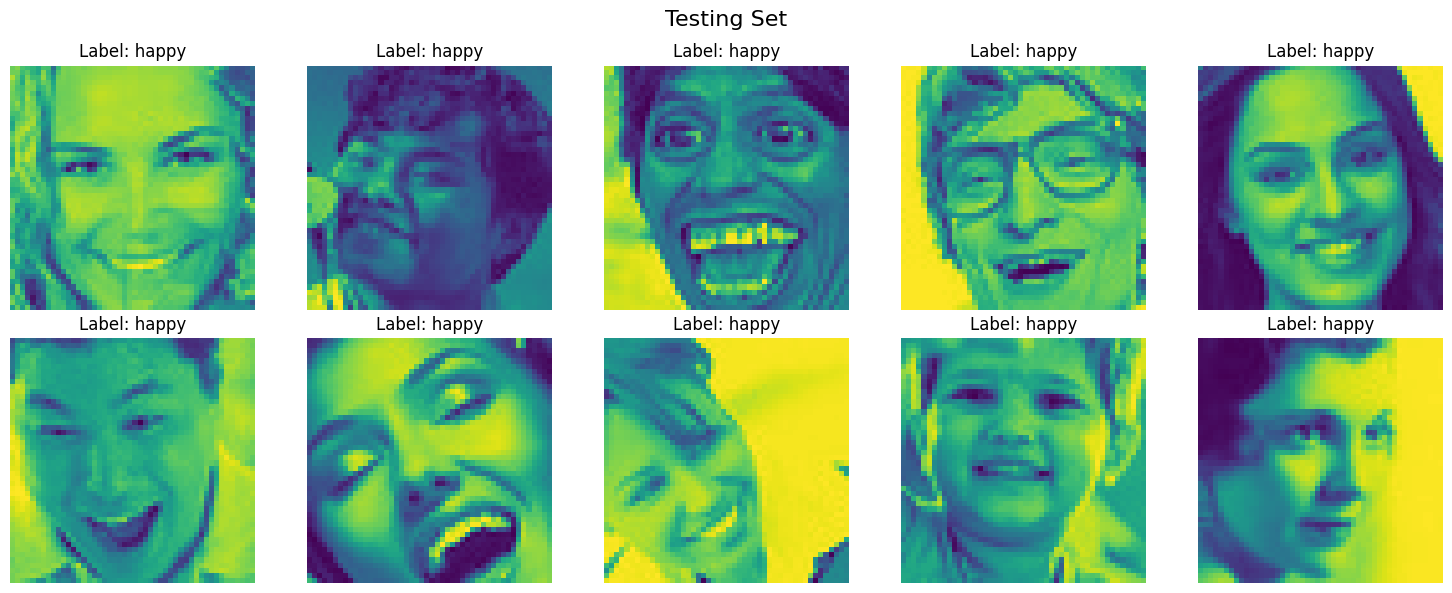

In [10]:
# Hanya menampilkan 10 gambar dari masing-masing set
def plot_images_from_generator(generator, title, num_images=10, images_per_row=5):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for i in range(num_images):
        img = images[i]
        label = labels[i]
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {list(generator.class_indices.keys())[label.argmax()]}")

    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_from_generator(traingen, "Training Set", num_images=10, images_per_row=5)
plot_images_from_generator(testgen, "Testing Set", num_images=10, images_per_row=5)

## 4.2 Distribusi kelas

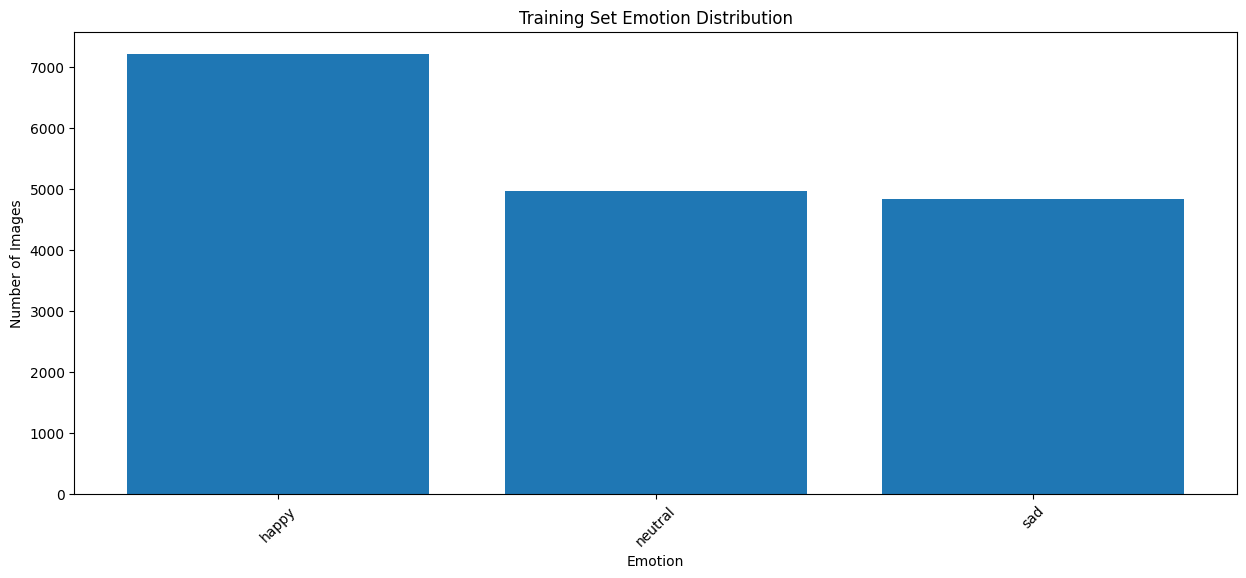

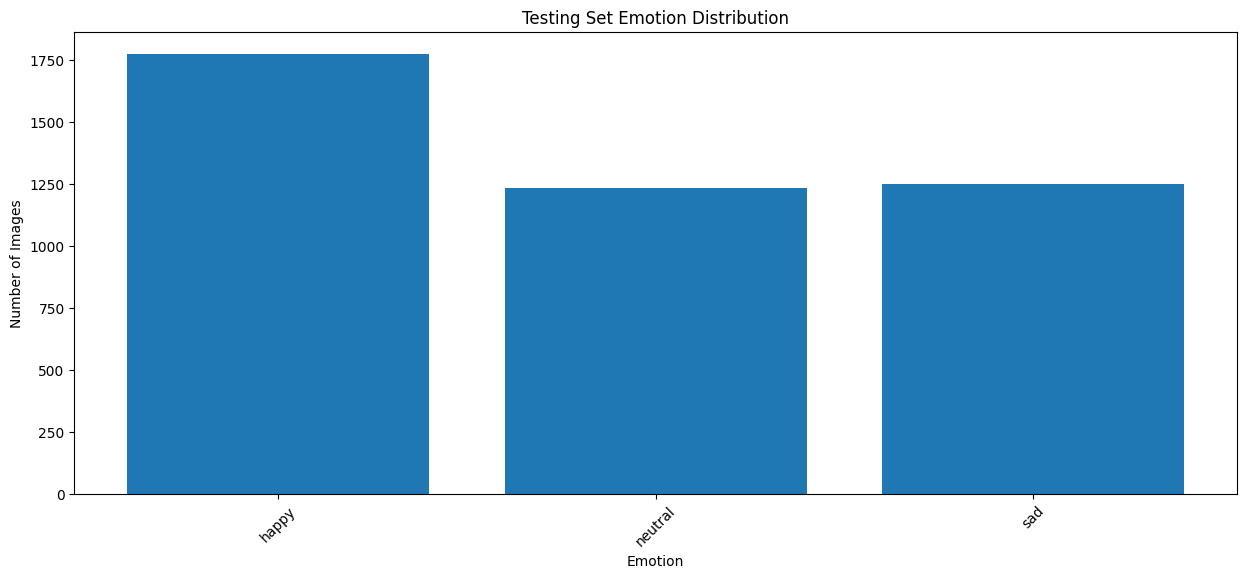

In [11]:
def plot_class_distribution(directory, title):
    class_names = os.listdir(directory)
    class_counts = []
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts.append(len(os.listdir(class_dir)))

    plt.figure(figsize=(15, 6))
    plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train, "Training Set Emotion Distribution")
plot_class_distribution(test, "Testing Set Emotion Distribution")

## 4.3 Mengonversi label numerik ke nama emosi

In [12]:
label_map = {0: 'happy', 1: 'neutral', 2: 'sad'}

# 5.CNN Model

## 5.1 CNN

In [13]:
model = Sequential()

# Block 1
model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Classifier
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))  # 3 label: happy, neutral, sad

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           38

 Total params: 2,328,003 (8.88 MB)

 Trainable params: 2,326,211 (8.87 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 5.2 Implementasi Callbacks

In [14]:
# Callback: menyimpan model terbaik selama training
mc = ModelCheckpoint("best_model.h5",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="max",
                             verbose=1)
# Implementasi Callbacks
es = EarlyStopping(
    monitor='val_loss',        # Memonitor nilai loss pada data validasi
    patience=25,               # Menghentikan pelatihan jika tidak ada perbaikan selama 25 epoch
    verbose=1,
    restore_best_weights=True # Mengembalikan bobot model terbaik saat pelatihan dihentikan
)

lr = ReduceLROnPlateau(
    monitor='val_loss',        # Memonitor nilai loss pada data validasi
    factor=0.001,              # Mengurangi learning rate menjadi 0.1% dari nilai sebelumnya
    patience=10,               # Jika tidak ada peningkatan selama 10 epoch, learning rate akan dikurangi
    verbose=1,
    min_delta=0.0001           # Minimal perubahan yang dianggap as an peningkatan
)

callbacks_list = [es, lr, mc]

## 5.3 Proses pelatihan model

In [15]:
# Proses pelatihan model
history = model.fit(
    traingen,
    epochs=100,
    validation_data=valgen,
    callbacks=callbacks_list
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3985 - loss: 1.3016
Epoch 1: val_accuracy improved from -inf to 0.41824, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - accuracy: 0.3986 - loss: 1.3012 - val_accuracy: 0.4182 - val_loss: 1.0768 - learning_rate: 3.0000e-04
Epoch 2/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4197 - loss: 1.0836
Epoch 2: val_accuracy improved from 0.41824 to 0.42471, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.4197 - loss: 1.0836 - val_accuracy: 0.4247 - val_loss: 1.0714 - learning_rate: 3.0000e-04
Epoch 3/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4285 - loss: 1.0758
Epoch 3: val_accuracy did not improve from 0.42471
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.4285 - loss: 1.0758 - val_accuracy: 0.4241 - val_loss: 1.0688 - learning_rate: 3.0000e-04
Epoch 4/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4180 - loss: 1.0794
Epoch 4: val_accuracy improved from 0.42471 to 0.43294, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.4180 - loss: 1.0794 - val_accuracy: 0.4329 - val_loss: 1.0626 - learning_rate: 3.0000e-04
Epoch 5/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4243 - loss: 1.0744
Epoch 5: val_accuracy did not improve from 0.43294
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.4243 - loss: 1.0744 - val_accuracy: 0.4235 - val_loss: 1.0651 - learning_rate: 3.0000e-04
Epoch 6/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4189 - loss: 1.0741
Epoch 6: val_accuracy did not improve from 0.43294
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.4189 - loss: 1.0741 - val_accuracy: 0.4235 - val_loss: 1.0598 - learning_rate: 3.0000e-04
Epoch 7/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4234 - loss: 1.0558
Epoch 7: val_accuracy did not improve from 0.43294
479/479 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.4234 - loss: 1.0558 - val_accuracy: 0.4241 - val_loss: 1.0422 - learning_rate: 3.0000

479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.4258 - loss: 0.9954 - val_accuracy: 0.4471 - val_loss: 0.9774 - learning_rate: 3.0000e-04
Epoch 10/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4637 - loss: 0.9719
Epoch 10: val_accuracy improved from 0.44706 to 0.53588, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.4638 - loss: 0.9719 - val_accuracy: 0.5359 - val_loss: 0.8878 - learning_rate: 3.0000e-04
Epoch 11/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4996 - loss: 0.9451
Epoch 11: val_accuracy improved from 0.53588 to 0.54882, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.4996 - loss: 0.9450 - val_accuracy: 0.5488 - val_loss: 0.8742 - learning_rate: 3.0000e-04
Epoch 12/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5194 - loss: 0.9040
Epoch 12: val_accuracy improved from 0.54882 to 0.60529, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.5194 - loss: 0.9040 - val_accuracy: 0.6053 - val_loss: 0.8032 - learning_rate: 3.0000e-04
Epoch 13/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5670 - loss: 0.8580
Epoch 13: val_accuracy did not improve from 0.60529
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.5670 - loss: 0.8580 - val_accuracy: 0.5929 - val_loss: 0.7972 - learning_rate: 3.0000e-04
Epoch 14/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5826 - loss: 0.8411
Epoch 14: val_accuracy did not improve from 0.60529
479/479 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.5826 - loss: 0.8410 - val_accuracy: 0.5841 - val_loss: 0.8249 - learning_rate: 3.0000e-04
Epoch 15/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5946 - loss: 0.8166
Epoch 15: val_accuracy improved from 0.60529 to 0.61471, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.5946 - loss: 0.8166 - val_accuracy: 0.6147 - val_loss: 0.7632 - learning_rate: 3.0000e-04
Epoch 16/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6019 - loss: 0.8021
Epoch 16: val_accuracy improved from 0.61471 to 0.61588, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.6019 - loss: 0.8021 - val_accuracy: 0.6159 - val_loss: 0.7928 - learning_rate: 3.0000e-04
Epoch 17/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6129 - loss: 0.7841
Epoch 17: val_accuracy did not improve from 0.61588
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.6129 - loss: 0.7841 - val_accuracy: 0.6159 - val_loss: 0.7529 - learning_rate: 3.0000e-04
Epoch 18/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6202 - loss: 0.7861
Epoch 18: val_accuracy did not improve from 0.61588
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.6202 - loss: 0.7860 - val_accuracy: 0.5594 - val_loss: 0.8973 - learning_rate: 3.0000e-04
Epoch 19/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6278 - loss: 0.7714
Epoch 19: val_accuracy improved from 0.61588 to 0.64882, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.6278 - loss: 0.7714 - val_accuracy: 0.6488 - val_loss: 0.7609 - learning_rate: 3.0000e-04
Epoch 20/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6363 - loss: 0.7505
Epoch 20: val_accuracy did not improve from 0.64882
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.6363 - loss: 0.7505 - val_accuracy: 0.6406 - val_loss: 0.7535 - learning_rate: 3.0000e-04
Epoch 21/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6490 - loss: 0.7389
Epoch 21: val_accuracy improved from 0.64882 to 0.69294, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.6490 - loss: 0.7389 - val_accuracy: 0.6929 - val_loss: 0.6947 - learning_rate: 3.0000e-04
Epoch 22/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6645 - loss: 0.7378
Epoch 22: val_accuracy did not improve from 0.69294
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.6645 - loss: 0.7378 - val_accuracy: 0.6888 - val_loss: 0.6908 - learning_rate: 3.0000e-04
Epoch 23/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6782 - loss: 0.7224
Epoch 23: val_accuracy did not improve from 0.69294
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.6781 - loss: 0.7225 - val_accuracy: 0.6653 - val_loss: 0.7264 - learning_rate: 3.0000e-04
Epoch 24/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6870 - loss: 0.7022
Epoch 24: val_accuracy improved from 0.69294 to 0.71294, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.6869 - loss: 0.7023 - val_accuracy: 0.7129 - val_loss: 0.6795 - learning_rate: 3.0000e-04
Epoch 25/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6883 - loss: 0.7105
Epoch 25: val_accuracy did not improve from 0.71294
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.6883 - loss: 0.7105 - val_accuracy: 0.7106 - val_loss: 0.6702 - learning_rate: 3.0000e-04
Epoch 26/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6832 - loss: 0.6956
Epoch 26: val_accuracy did not improve from 0.71294
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.6832 - loss: 0.6956 - val_accuracy: 0.6724 - val_loss: 0.7080 - learning_rate: 3.0000e-04
Epoch 27/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6845 - loss: 0.6962
Epoch 27: val_accuracy did not improve from 0.71294
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.6845 - loss: 0.6962 - val_accuracy: 0.7047 - val_loss: 0.6707 - learning_rate: 

479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.6947 - loss: 0.6836 - val_accuracy: 0.7141 - val_loss: 0.6497 - learning_rate: 3.0000e-04
Epoch 29/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7003 - loss: 0.6818
Epoch 29: val_accuracy improved from 0.71412 to 0.72059, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.7004 - loss: 0.6818 - val_accuracy: 0.7206 - val_loss: 0.6723 - learning_rate: 3.0000e-04
Epoch 30/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7094 - loss: 0.6631
Epoch 30: val_accuracy did not improve from 0.72059
479/479 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.7094 - loss: 0.6631 - val_accuracy: 0.7135 - val_loss: 0.6385 - learning_rate: 3.0000e-04
Epoch 31/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7172 - loss: 0.6574
Epoch 31: val_accuracy did not improve from 0.72059
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.7172 - loss: 0.6575 - val_accuracy: 0.7206 - val_loss: 0.6307 - learning_rate: 3.0000e-04
Epoch 32/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7184 - loss: 0.6514
Epoch 32: val_accuracy did not improve from 0.72059
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7184 - loss: 0.6514 - val_accuracy: 0.7176 - val_loss: 0.6546 - learning_rate: 

479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.7208 - loss: 0.6379 - val_accuracy: 0.7294 - val_loss: 0.6486 - learning_rate: 3.0000e-04
Epoch 34/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7121 - loss: 0.6521
Epoch 34: val_accuracy improved from 0.72941 to 0.73294, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7121 - loss: 0.6521 - val_accuracy: 0.7329 - val_loss: 0.6289 - learning_rate: 3.0000e-04
Epoch 35/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7210 - loss: 0.6393
Epoch 35: val_accuracy did not improve from 0.73294
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.7210 - loss: 0.6393 - val_accuracy: 0.6994 - val_loss: 0.6871 - learning_rate: 3.0000e-04
Epoch 36/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7340 - loss: 0.6177
Epoch 36: val_accuracy improved from 0.73294 to 0.73588, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7339 - loss: 0.6178 - val_accuracy: 0.7359 - val_loss: 0.5991 - learning_rate: 3.0000e-04
Epoch 37/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7331 - loss: 0.6328
Epoch 37: val_accuracy improved from 0.73588 to 0.74412, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.7331 - loss: 0.6328 - val_accuracy: 0.7441 - val_loss: 0.6145 - learning_rate: 3.0000e-04
Epoch 38/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7301 - loss: 0.6318
Epoch 38: val_accuracy did not improve from 0.74412
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7301 - loss: 0.6318 - val_accuracy: 0.7335 - val_loss: 0.5959 - learning_rate: 3.0000e-04
Epoch 39/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7355 - loss: 0.6170
Epoch 39: val_accuracy did not improve from 0.74412
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.7355 - loss: 0.6170 - val_accuracy: 0.7406 - val_loss: 0.5965 - learning_rate: 3.0000e-04
Epoch 40/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7338 - loss: 0.6332
Epoch 40: val_accuracy did not improve from 0.74412
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7338 - loss: 0.6331 - val_accuracy: 0.7118 - val_loss: 0.6406 - learning_rate: 

479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.7446 - loss: 0.5950 - val_accuracy: 0.7529 - val_loss: 0.5756 - learning_rate: 3.0000e-04
Epoch 46/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7418 - loss: 0.5995
Epoch 46: val_accuracy did not improve from 0.75294
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7418 - loss: 0.5995 - val_accuracy: 0.7476 - val_loss: 0.6015 - learning_rate: 3.0000e-04
Epoch 47/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7523 - loss: 0.5821
Epoch 47: val_accuracy did not improve from 0.75294
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.7523 - loss: 0.5821 - val_accuracy: 0.7482 - val_loss: 0.5879 - learning_rate: 3.0000e-04
Epoch 48/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7500 - loss: 0.5770
Epoch 48: val_accuracy did not improve from 0.75294
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7499 - loss: 0.5770 - val_accuracy: 0.7494 - val_loss: 0.5818 - learning_rate: 

479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.7606 - loss: 0.5768 - val_accuracy: 0.7635 - val_loss: 0.5595 - learning_rate: 3.0000e-04
Epoch 56/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7531 - loss: 0.5707
Epoch 56: val_accuracy did not improve from 0.76353
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7531 - loss: 0.5707 - val_accuracy: 0.7594 - val_loss: 0.5756 - learning_rate: 3.0000e-04
Epoch 57/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7492 - loss: 0.5744
Epoch 57: val_accuracy improved from 0.76353 to 0.76471, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.7492 - loss: 0.5744 - val_accuracy: 0.7647 - val_loss: 0.5600 - learning_rate: 3.0000e-04
Epoch 58/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7611 - loss: 0.5607
Epoch 58: val_accuracy did not improve from 0.76471
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7611 - loss: 0.5607 - val_accuracy: 0.7535 - val_loss: 0.5743 - learning_rate: 3.0000e-04
Epoch 59/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7558 - loss: 0.5683
Epoch 59: val_accuracy did not improve from 0.76471
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.7558 - loss: 0.5683 - val_accuracy: 0.7559 - val_loss: 0.5442 - learning_rate: 3.0000e-04
Epoch 60/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7703 - loss: 0.5506
Epoch 60: val_accuracy did not improve from 0.76471
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7703 - loss: 0.5507 - val_accuracy: 0.7459 - val_loss: 0.5952 - learning_rate: 

479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7692 - loss: 0.5631 - val_accuracy: 0.7682 - val_loss: 0.5616 - learning_rate: 3.0000e-04
Epoch 63/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7651 - loss: 0.5456
Epoch 63: val_accuracy did not improve from 0.76824
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.7651 - loss: 0.5456 - val_accuracy: 0.7676 - val_loss: 0.5659 - learning_rate: 3.0000e-04
Epoch 64/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7663 - loss: 0.5539
Epoch 64: val_accuracy did not improve from 0.76824
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.7663 - loss: 0.5539 - val_accuracy: 0.7553 - val_loss: 0.5606 - learning_rate: 3.0000e-04
Epoch 65/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7635 - loss: 0.5476
Epoch 65: val_accuracy did not improve from 0.76824
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.7635 - loss: 0.5477 - val_accuracy: 0.7618 - val_loss: 0.5603 - learning_rate: 

479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.7696 - loss: 0.5462 - val_accuracy: 0.7771 - val_loss: 0.5477 - learning_rate: 3.0000e-07
Epoch 71/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7580 - loss: 0.5511
Epoch 71: val_accuracy did not improve from 0.77706
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.7580 - loss: 0.5511 - val_accuracy: 0.7618 - val_loss: 0.5673 - learning_rate: 3.0000e-07
Epoch 72/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7759 - loss: 0.5406
Epoch 72: val_accuracy did not improve from 0.77706
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.7759 - loss: 0.5406 - val_accuracy: 0.7606 - val_loss: 0.5525 - learning_rate: 3.0000e-07
Epoch 73/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7765 - loss: 0.5331
Epoch 73: val_accuracy improved from 0.77706 to 0.78294, saving model to best_model.h5


479/479 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.7765 - loss: 0.5331 - val_accuracy: 0.7829 - val_loss: 0.5290 - learning_rate: 3.0000e-07
Epoch 74/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7686 - loss: 0.5422
Epoch 74: val_accuracy did not improve from 0.78294
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.7686 - loss: 0.5422 - val_accuracy: 0.7571 - val_loss: 0.5591 - learning_rate: 3.0000e-07
Epoch 75/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7650 - loss: 0.5460
Epoch 75: val_accuracy did not improve from 0.78294
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.7650 - loss: 0.5460 - val_accuracy: 0.7671 - val_loss: 0.5498 - learning_rate: 3.0000e-07
Epoch 76/100
478/479 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7722 - loss: 0.5304
Epoch 76: val_accuracy did not improve from 0.78294
479/479 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.7722 - loss: 0.5304 - val_accuracy: 0.7735 - val_loss: 0.5354 - learning_rate: 

# 6.Evaluation Model & Metrics

## 6.1 Uji Generalisasi Model terhadap Data Test

In [20]:
test_loss, test_accuracy = model.evaluate(testgen)

133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8773 - loss: 0.3286


## 6.2 Confusion Matrix

Test Accuracy: 0.79
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1774
           1       0.67      0.73      0.70      1233
           2       0.74      0.68      0.71      1247

    accuracy                           0.79      4254
   macro avg       0.78      0.78      0.78      4254
weighted avg       0.79      0.79      0.79      4254

Confusion Matrix:
[[1627  107   40]
 [  83  897  253]
 [  67  331  849]] 




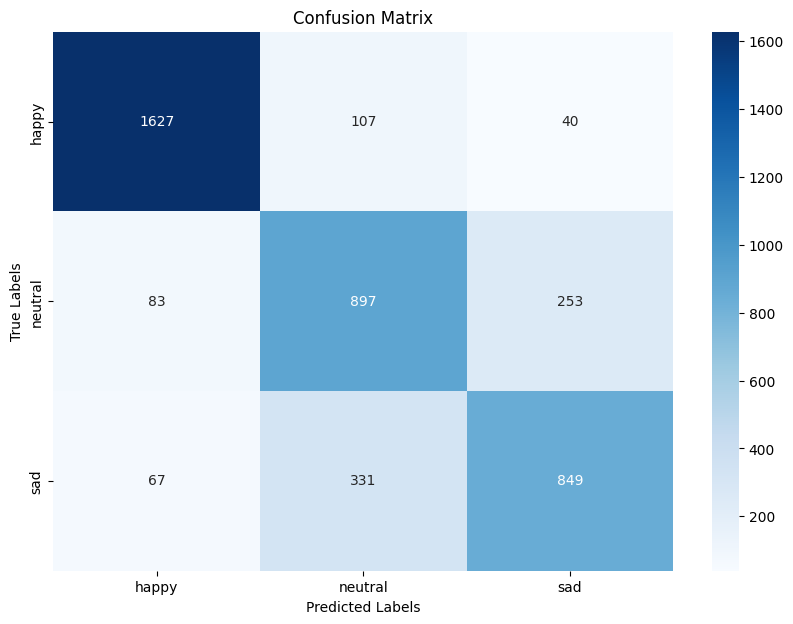

Training class indices: {'happy': 0, 'neutral': 1, 'sad': 2}
Test class indices: {'happy': 0, 'neutral': 1, 'sad': 2}


In [21]:
print(f"Test Accuracy: {test_accuracy:.2f}")
y_pred = np.argmax(model.predict(testgen), axis=1)
y_true = testgen.classes
print("Classification Report:")
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix,'\n\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print("Training class indices:", traingen.class_indices)
print("Test class indices:", testgen.class_indices)

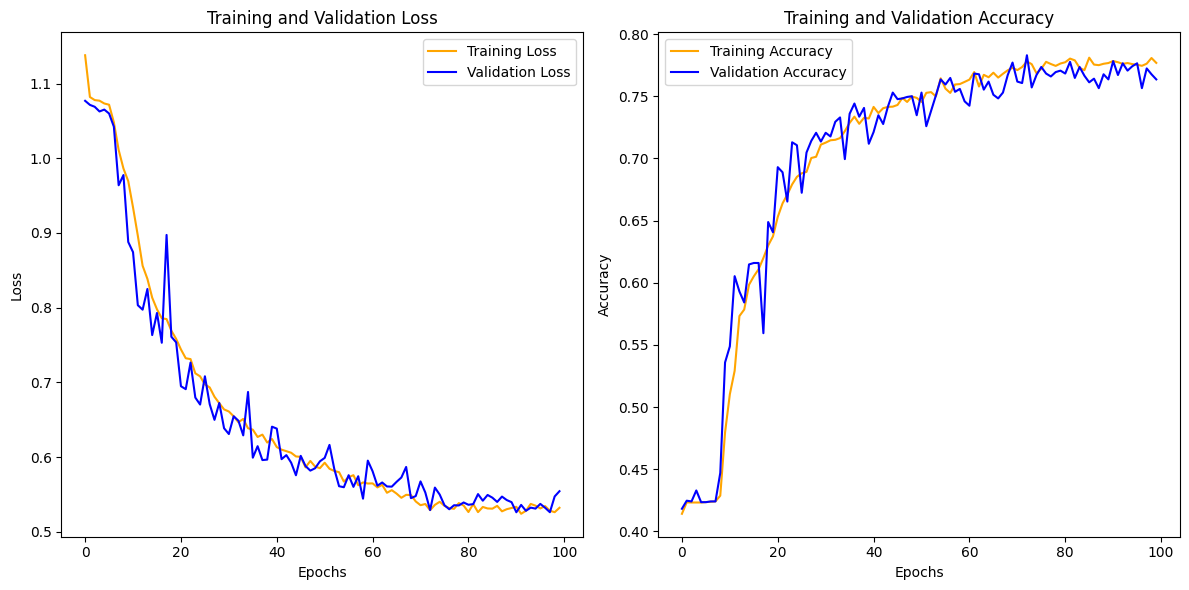

In [22]:
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='orange')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 6.3 ROC dan AUC

133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


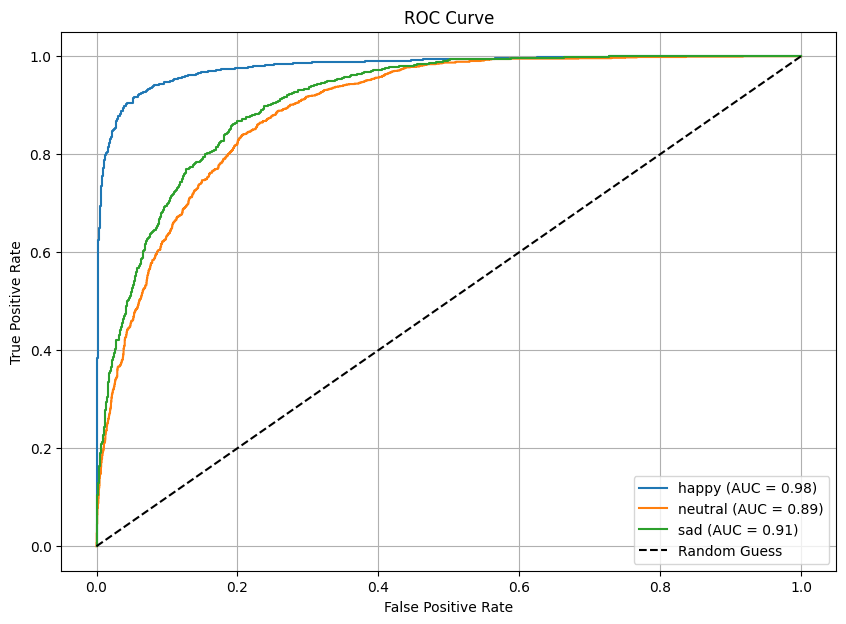

In [25]:
# Convert true labels to one-hot encoding for ROC calculations
y_true_onehot = label_binarize(y_true, classes=[0, 1, 2])
y_pred_prob = model.predict(testgen)

plt.figure(figsize=(10, 7))

# Plot ROC for each class
for i, class_name in label_map.items():
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 7.Test Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image: /content/Happy.jpg
Predicted label: Happy
Confidence: 1.0000


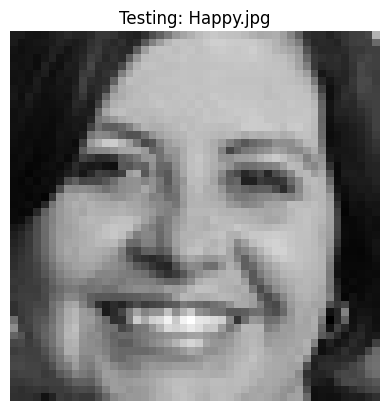

In [30]:
image_paths = ["/content/Happy.jpg"]
label_map = ['Happy', 'Sad', 'Neutral']

for img_path in image_paths:
    img = image.load_img(img_path, target_size=(48, 48), color_mode="grayscale")
    img_array = np.array(img)

    plt.imshow(img_array, cmap='gray')
    plt.title(f"Testing: {img_path.split('/')[-1]}")
    plt.axis('off')

    # Persiapan untuk prediksi
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed = img_processed.reshape(1, 48, 48, 1)

    result = model.predict(img_processed)
    result_list = list(result[0])

    # Menampilkan hasil prediksi
    predicted_index = result_list.index(max(result_list))
    predicted_label = label_map[predicted_index]

    print(f"Image: {img_path}")
    print(f"Predicted label: {predicted_label}")
    print(f"Confidence: {max(result_list):.4f}")

    plt.show()

# 8.Save Model

In [31]:
# model.save('model 3 label.h5')